In [1]:
from IPython.core.display import HTML, Markdown, display

import numpy.random as npr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf

import ipywidgets as widgets

import requests
import zipfile
import os
import shutil
import nibabel
from scipy.stats import gamma

# Enable plots inside the Jupyter Notebook
%matplotlib inline

# Signal detection simulation: Part 1

Authored by *Liang Zhli*, *Clay Curtis* and and *Todd Gureckis*.
Justin Gardner's [Signal Detection Tutorial](http://gru.stanford.edu/doku.php/tutorials/sdt) but translated from MATLAB to Python.

We're going to simulate a signal detection experiment and an “ideal observer” (an observer who behaves exactly according to signal detection theory). This is always a useful thing to do when trying to understand a decision model, experimental method or an analysis tool. You get to control and play around with the simulation to see what effect it has on the analysis that comes out.


On each trial, our observer sees an element sampled from either the signal present gaussian distribution or the signal absent distribution, which is also gaussian with the same standard deviation. The observer chooses to say “signal present” when the signal they see on that trial is above criterion and “signal absent” otherwise. The picture you 
should have in your head is this:

<img src="http://gru.stanford.edu/lib/exe/fetch.php/tutorials/nobias.png?w=&h=&cache=cache">



<div class="alert alert-info" role="alert">
  <strong>Question 1</strong> <br>
    To check your understanding we will first have you create SDT type figures matching a few example situations.  Using the code provided below, please create figures matching the following situations:
    <ul>
        <li>Draw two bell-shaped curves on the same plot (Gaussian distributions) with the same mean, but different standard deviations.</li>
        <li>Next draw two bell-shaped curves (Gaussian distributions) with  the same standard deviations, but different means.</li>
        <li>Next draw one signal-detection-theory plot for a subject who has POOR discrimination, and another signal-detection-theory plot for a different subject is has GOOD discrimination.  </li>
        <li> On the SDT plots that you just completed, draw a liberal criterion for one subject, and a conservative criterion for the other. Label each of these clearly. </li>
        <li>Describe in a markdown cell which parts of the graphs reflect the criterion, misses, false alarms, hits, and correct rejections.</li>
    </ul>
</div>

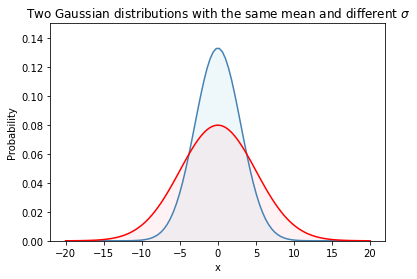

In [2]:
x = np.linspace(-20, 20, 100)
p1 = stats.norm.pdf(x, 0, 3)
p2 = stats.norm.pdf(x, 0, 5)

plt.plot(x, p1, color='steelblue')
plt.fill_between(x, p1, interpolate=True, facecolor='lightblue', alpha=0.2)

plt.plot(x, p2, color='red')
plt.fill_between(x, p2, interpolate=True, facecolor='pink', alpha=0.2)

plt.ylim(0, 0.15)
plt.ylabel("Probability")
plt.xlabel("x")
plt.title(
    "Two Gaussian distributions with the same mean and different $\sigma$")

plt.show()

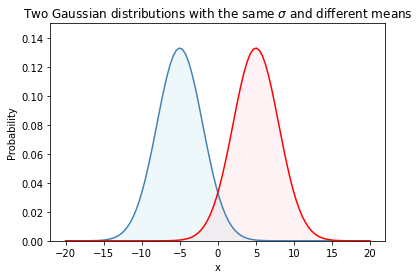

In [3]:
x = np.linspace(-20, 20, 100)
p1 = stats.norm.pdf(x, -5, 3)
p2 = stats.norm.pdf(x, 5, 3)

plt.plot(x, p1, color='steelblue')
plt.fill_between(x, p1, interpolate=True, facecolor='lightblue', alpha=0.2)

plt.plot(x, p2, color='red')
plt.fill_between(x, p2, interpolate=True, facecolor='pink', alpha=0.2)

plt.ylim(0, 0.15)
plt.ylabel("Probability")
plt.xlabel("x")
plt.title(
    "Two Gaussian distributions with the same $\sigma$ and different means")

plt.show()

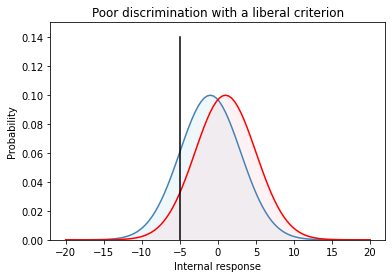

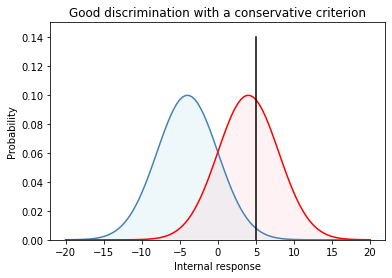

In [4]:
x = np.linspace(-20, 20, 100)
# Poor discrimination
noise = stats.norm.pdf(x, -1, 4)
signalnoise = stats.norm.pdf(x, 1, 4)

plt.plot(x, noise, color='steelblue')
plt.fill_between(x, noise, interpolate=True, facecolor='lightblue', alpha=0.2)

plt.plot(x, signalnoise, color='red')
plt.fill_between(x, signalnoise, interpolate=True, facecolor='pink', alpha=0.2)

plt.ylim(0, 0.15)
plt.ylabel("Probability")
plt.xlabel("Internal response")
plt.title("Poor discrimination with a liberal criterion")
plt.plot([-5, -5], [0, 0.14], color='k')

plt.show()

# Good discrimination
noise = stats.norm.pdf(x, -4, 4)
signalnoise = stats.norm.pdf(x, 4, 4)

plt.plot(x, noise, color='steelblue')
plt.fill_between(x, noise, interpolate=True, facecolor='lightblue', alpha=0.2)

plt.plot(x, signalnoise, color='red')
plt.fill_between(x, signalnoise, interpolate=True, facecolor='pink', alpha=0.2)

plt.ylim(0, 0.15)
plt.ylabel("Probability")
plt.xlabel("Internal response")
plt.title("Good discrimination with a conservative criterion")
plt.plot([5, 5], [0, 0.14], color='k')

plt.show()

- **Criterion** is the black line.
- **Hits** is the area on the right of criterion under the red (signal and noise) curve.
- **Misses** is the area on the left of criterion under the red (signal and noise) curve.
- **Correct rejections** is the area on the left of criterion under the blue (noise) curve.
- **False alarms** is the area on the right of criterion under the blue (noise) curve.

## Make `signal_present` array

So, here goes. First let's make a sequence of n = 1000 trials in which 50% randomly are going to have “signal” and 50% are randomly going to have no signal. To do that we want to create an array called `signal_present` that is True 50% of the time and False 50% of the time.

In [5]:
signal_present = np.random.rand(1000) > .5

We can make a heatmap to show the binary values:

<AxesSubplot:>

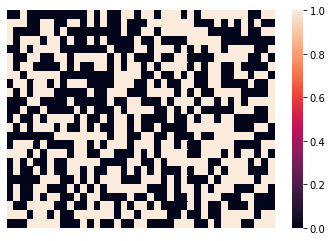

In [6]:
sns.heatmap(signal_present.reshape(25, 40),
            linewidths=0,
            xticklabels=False,
            yticklabels=False)

## Make signal array 

Ok, now we want to simulate the **signal** that the observer actually gets to base the decision on. Remember that in applying signal detection to cognitive neuroscience you should be thinking of the signal as a neuron or population of neurons response and that the magnitude of this response (e.g. spikes per second) is monotonically related to the actual signal strength. The signal is corrupted by random noise. In particular, signal trials should come from some gaussian distribution and noise trials should come from another gaussian distribution that differ only in the means. This is an assumption about the process that is termed $iid$ - the signal and noise come from independent identical distributions.

Ok, let's make a new array from our `signal_present` array such that on signal present trials (i.e. when `signal_present == 1`), values are picked from a gaussian distribution with standard deviation of 1 who's mean is 1 and on signal absent trials (i.e. when `signal_present == 0`), values are picked from a gaussian distribution with standard deviation of 1 (that's the identical part of the $iid$ assumption) but who's mean is 0.

In [7]:
signal = np.random.normal(0, 1, size=signal_present.size)
signal[signal_present] = np.random.normal(2, 1, size=signal_present.sum())

We can look at a heatmap of the signal values:

<AxesSubplot:>

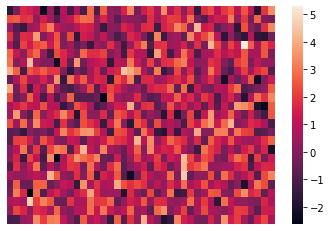

In [8]:
sns.heatmap(signal.reshape(25, 40),
            linewidths=0,
            xticklabels=False,
            yticklabels=False)

This is somewhat helpful, but it doesn't really show us the distribution of values. To do that, let's first put all the data into a pandas data frame.

In [9]:
df = pd.DataFrame({
    "trial": range(len(signal)),
    "signal_present": signal_present,
    "signal": signal
})
df.head()

,trial,signal_present,signal
0,0,False,-1.728234
1,1,False,-0.190480
2,2,True,1.688458
3,3,False,1.430162
4,4,False,0.892302


Then let's make a histogram and density plot.

<div class="alert alert-info" role="alert">
  <strong>Question 2</strong> <br>
    Using seaborn's `distplot()` create a histogram and density plot of the signal column from our data frame.
</div>

/Users/peilingjiang/Documents/cognition_env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='signal', ylabel='Density'>

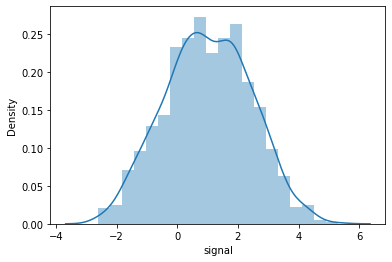

In [10]:
sns.distplot(df.signal)

<div class="alert alert-info" role="alert">
  <strong>Question 3</strong> <br>
    Using `distplot()` (called twice to stack the plots together) create a histogram of the signal present data separately from the signal absent data.  Hint, you can select only the signal present data by df.signal[df.signal_present].  Second hint: the `~` character means "not" or "opposite".
</div>

/Users/peilingjiang/Documents/cognition_env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/peilingjiang/Documents/cognition_env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='signal', ylabel='Density'>

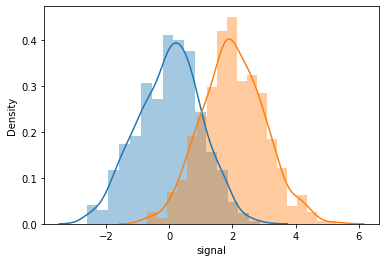

In [11]:
sns.distplot(df.signal[~df.signal_present])
sns.distplot(df.signal[df.signal_present])

<div class="alert alert-info" role="alert">
  <strong>Question 4</strong> <br>
    Now confirm numerically that the means and standard deviations of the signal present and signal absent data are approximately what they should be (hint: use the .mean() function in pandas).
</div>

In [12]:
noise = df.signal[~df.signal_present]
signal = df.signal[df.signal_present]

print(
    f"For the signal present data, mean is {signal.mean()} and standard deviation is {signal.std()}."
)
print(
    f"For the signal absent data, mean is {noise.mean()} and standard deviation is {noise.std()}."
)

For the signal present data, mean is 2.017551267989431 and standard deviation is 0.9923372942820919.
For the signal absent data, mean is 0.0038491605641474505 and standard deviation is 1.0009249362992911.


Ok, we're good to go. We have created the stimulus that our ideal observer will get to see (`signal`) and we know which of the trials come from the signal and which from the absent distributions (`signal_present`).

## Make ideal observer responses

Now we are going to simulate an *ideal observer* which will behave just as signal detection says. They will choose signal present (response = 1) when the signal they get to see (signal array from above) is greater than their internal criterion and they will choose signal absent (response = 0) when the signal is below their internal criterion.

Let's start by making the criterion right in between the signal present and absent distributions that we created above. That is, let's set criterion to 0.5 and make an array of responses:

In [13]:
df['response'] = df.signal > .5

In [14]:
df.head()

,trial,signal_present,signal,response
0,0,False,-1.728234,False
1,1,False,-0.190480,False
2,2,True,1.688458,True
3,3,False,1.430162,True
4,4,False,0.892302,True


Let's make a heatmap like before

<AxesSubplot:>

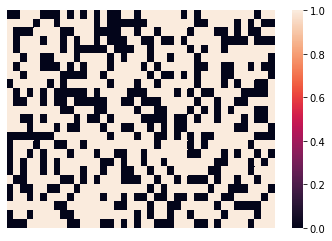

In [15]:
sns.heatmap(df.response.values.reshape(25, 40),
            linewidths=0,
            xticklabels=False,
            yticklabels=False)

Again, not too informative, but it would help us catch strange cases like response always being `True`, which might indicate a problem in the code.

## Calculate hits, misses, correct-rejects and false-alarms

Ok, so now we have our experiment dataframe (`signal_present`) a simulation of the signal it generates in the observer (`signal`) and the ideal observers responses (`response`).

From these you should be able to calculate hits, misses, correct rejects and false alarms.

In [16]:
hit = df.response[df.signal_present]
miss = ~df.response[df.signal_present]
fa = df.response[~df.signal_present]
cr = ~df.response[~df.signal_present]

In [17]:
print("Hit rate: {:.2f}".format(hit.mean()))
print("Miss rate: {:.2f}".format(miss.mean()))
print("False alarm rate: {:.2f}".format(fa.mean()))
print("Correct rejection rate: {:.2f}".format(cr.mean()))

Hit rate: 0.95
Miss rate: 0.05
False alarm rate: 0.32
Correct rejection rate: 0.68


## Calculate $d'$

Now let's calculate $d'$.

<div class="alert alert-info" role="alert">
  <strong>Question 5</strong> <br>
What should $d'$ be given how we made the signal and noise distributions?  Refer to the slides or chapte reading to remember the formula for d'.
</div>

d' is the standardized difference between the means of the Signal Present and Signal Absent distributions.

In [18]:
sig = 1
d_prime = (signal.mean() - noise.mean()) / sig
d_prime

2.0137021074252837

The picture you should have in mind is:

<img src=http://gru.stanford.edu/lib/exe/fetch.php/tutorials/neuraldprime.png>



Ok, now we know what it should be in an ideal world we're ready to think about the approach for computing $d'$ from behavioral data?

$$d' = z(\textrm{hits}) - z(\textrm{false alarms})$$

So, how do we calculate those $z$'s?

$z$ means the distance in units of standard deviation from the center of a gaussian distribution such that the area under the curve to the right of that is the proportion hits or false alarms that we measured in the experiment. By convention, center of the distribution is 0, and criterion to the left are positive. The picture you should have for example if $z$ is 1 (giving an area under the curve to the right of that of 0.84 is):

<img src=http://gru.stanford.edu/lib/exe/fetch.php/tutorials/zof1.png>

The problem is that we don't have the zscore for the hits directly.  Instead we have the proportion of hits or false alarms.  Interestingly those values relate directly to the area under the curve of the signal strength/internal response distributions.  Thus we can use the **inverse cumulative density** function or inverse CDF to look up the z-score associated with a particular area under the curve for a standard normal (mean=0, sd=1).

To get this area you can use the `stats.norm.ppf()` function which gives the inverse of the cumulative density function. It's the cumulative density function since you are interested in the area under the gaussian probability density function, and its the inverse since you are going from the area, back to the $z$ (units of std of the gaussian).

In [19]:
from scipy import stats

dprime = stats.norm.ppf(hit.mean()) - stats.norm.ppf(fa.mean())
print("d prime: {:.2f}".format(dprime))

d prime: 2.07


<div class="alert alert-success" role="alert">
  <strong>Stop and think</strong> <br>
  How close is the d' you got to the expected value? Why is it different?
</div>



## Different criterion

Now let's simulate an observer that doesn't want to miss as much and see if we get a similar $d'$ from the data.

In [44]:
df['response'] = df.signal > 0.999

In [45]:
hit = df.response[df.signal_present]
fa = df.response[~df.signal_present]
dprime = stats.norm.ppf(hit.mean()) - stats.norm.ppf(fa.mean())
print("d prime: {:.2f}".format(dprime))

d prime: 2.01


<div class="alert alert-success" role="alert">
  <strong>Stop and think</strong> <br>
  Did d' change?  Try a few other threshold rules.  Is it always the same value?  Is that what you expected?  If not why do you think it changes?
</div>

## Bias or criterion

Another value of interest in a signal detection analysis the the bias or criteiron.  Response bias in a yes/no task is often quantified with $\beta$. Use of this measure assumes that responses are based on a likelihood ratio.  However, a somewhat more popular alternative is a measure/statitistic known as $c$.  $c$ is defined as the distance between the criterion and the neutral point, where neither response is favored.  If the criterion is lo- cated at this point, c has a value of 0. Deviations from the neutral point are measured in standard deviation units. Negative values of c signify a bias toward responding yes (the criterion lies to the left of the neutral point), whereas positive values signify a bias toward the no response (the criterion lies to the right of the neutral point).

In [46]:
c = -(stats.norm.ppf(hit.mean()) + stats.norm.ppf(fa.mean())) / 2.0
print("c: {:.2f}".format(c))

c: -0.01


<div class="alert alert-success" role="alert">
  <strong>Stop and think</strong> <br>
  What value of the response threshold above will make c closer to or equal to zero?  Try adjusting it until you find the value.  Think about why that is.
</div>

## ROC calculation

Now, let's make an ROC curve. In some ways a ROC curve is a more theoretical object because it can be difficult to construct it for a simple detection experiment.  In fact, for the simulated data we have been dealing with so far, it is not possible to plot the entire ROC curve because we don't know exactly how the subject might perform using a threshold different than the one we saw them adopt.

However, if we can draw simulated samples from the signal and noise distributions we can draw the expected curve by applying different values of the threshold ourselves. In values of the spike counts for the neurons preferred direction (signal) and the neurons anti-preferred direction (noise, what they called the anti-neuron). Will just do it by pulling actual values from a signal distribution that is gaussian with mean of 1 and standard deviation of 1, just like we did above. For the noise, let's do mean of 0 and standard deviation of 1. Make two arrays of length n = 1000, one for signal and noise using the techniques from above:

In [23]:
n = 1000
signal = np.random.normal(1, 1, n)
noise = np.random.normal(0, 1, n)

Check that the procedure worked by computing the means and standard deviations of signal and noise and making sure that they are what you expected (always good to double check everything when programming to make sure that things are working out the way you expected).

In [24]:
print("Signal mean +/- std: {:.2f} ({:.2f})".format(signal.mean(),
                                                    signal.std()))
print("Noise mean +/- std: {:.2f} ({:.2f})".format(noise.mean(), noise.std()))

Signal mean +/- std: 1.01 (1.01)
Noise mean +/- std: 0.02 (1.04)


It's also helpful to make plots like we did above:

/Users/peilingjiang/Documents/cognition_env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/peilingjiang/Documents/cognition_env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


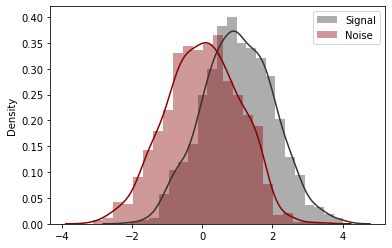

In [25]:
sns.distplot(signal, color=".2", label="Signal")
sns.distplot(noise, color="darkred", label="Noise")
plt.legend()

Ok, how do we compute the ROC curve? What's on those two axes. Remember?

<img src=http://gru.stanford.edu/lib/exe/fetch.php/tutorials/basicroc.png>

Ok, so that is computed for various criterions, right? So, if you think you know how, try to compute a curve from the signal and noise distributions.



First we need to create a large number of different criterion values.  How about 100 different values between 10 and -10 using `np.linspace()`.

In [26]:
criterions = np.linspace(10, -10, 100)

Now for each setting of the criterion we can compute the hit and false alarm rate.

In [27]:
hit_rates = [(signal > c).mean() for c in criterions]
fa_rates = [(noise > c).mean() for c in criterions]

Ok, now plot it:

[Text(0.5, 0, 'FA Rate'), Text(0, 0.5, 'Hit Rate')]

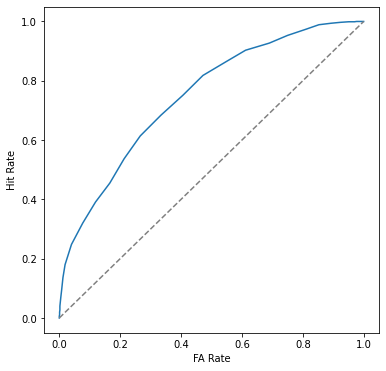

In [28]:
f, ax = plt.subplots(figsize=(6, 6))
ax.plot(fa_rates, hit_rates)
ax.plot([0, 1], [0, 1], ls="--", c=".5")
ax.set(xlabel="FA Rate", ylabel="Hit Rate")

Finally, one interesting fact is that the area under the ROC is equal to performance on a two alternative forced choice task (2AFC). So, calculate the area under the curve and see what you get.

In [29]:
from scipy.integrate import trapz

auc = trapz(hit_rates, fa_rates)  # this does the integral under the ROC curve
print("Area under ROC curve: {:.2f}".format(auc))

Area under ROC curve: 0.75


What did you get? Is it right? Well, one way to check is to see if a simulation of 2AFC will give you the same (or numerically similar) values. The experimental logic says that if signal is greater than noise then the ideal observer will get the 2AFC right, otherwise the observer will choose the noise interval and get it wrong. So, that's pretty easy to simulate. Try it!

In [30]:
afc_perf = (signal > noise).mean()
print("2AFC performance: {:.2f}".format(afc_perf))

2AFC performance: 0.75


<div class="alert alert-info" role="alert">
  <strong>Question 6</strong> <br>
    In what we just described, I suggested that you can't compute the ROC curve unless you have samples from the underlying internal response distributions (e.g., neural spike counts).  Is this correct?  Think about what the meaning of the ROC curve is.  Can you think of a way to assess it using an experiment where the primary data are just the false alarms and hits for different conditions? 
</div>

No, one doesn't have to have access to the internal response distribution to plot the empirical ROC curve, which reflects the relationship between the false alarm rate and hit rate - directly observable from an experiment. It is possible to assess it using an experiment, while assumption needs to be made, i.e. the internal response distributions follow are both normal and follow the shape we have been dealing with above. Then, we can fit the model for means and sigmas with the data we have.

<div class="alert alert-info" role="alert">
  <strong>Question 7</strong> <br>
    In the example reported above we computed the hits, false alarms, misses, and correct rejections, along with the $d'$ and $c$ values for a case where the signal absent distribution had mean 0 and standard deviation 1 while the signal present distribution had a mean 1 and standard deviation 1.  Recompute these statistics for a case where the mean of the signal distirbution is 2 and the criterion is 0.4.  What effect does this have on d'?  
</div>

In [31]:
n = 1000
signal = np.random.normal(2, 1, n)
noise = np.random.normal(0, 1, n)

Text(0, 0.5, 'd prime')

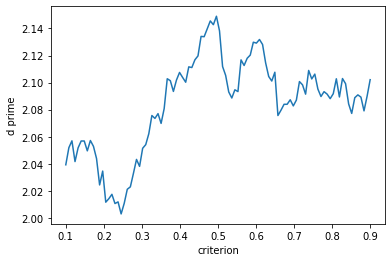

In [32]:
criterions = np.linspace(0.9, 0.1, 100)
hit_rates = [(signal > c).mean() for c in criterions]
fa_rates = [(noise > c).mean() for c in criterions]
dprime = [
    stats.norm.ppf(h) - stats.norm.ppf(fa_rates[ind])
    for ind, h in enumerate(hit_rates)
]

plt.plot(criterions, dprime)
plt.xlabel('criterion')
plt.ylabel("d prime")

Increasing the mean of the signal distribution, thus increasing the difference between the two distributions, will increase d'. As d' is a measure of the strength of the internal response that is independent of the criterion, it is hard to tell how the criterion change affects d'.